In [1]:
from tqdm import trange
from tqdm.notebook import tqdm, trange
from numpy.fft import fft2, fftfreq, fftshift, ifft2
from typing import List
from functools import partial
import sys
import itertools
from gdsfactory.get_netlist import get_netlist as _get_netlist
from pprint import pprint
from omegaconf import OmegaConf
import numpy as np
# from sklearn.linear_model import LinearRegression
from scipy.constants import c
from gdsfactory.simulation.get_sparameters_path import get_sparameters_path_lumerical
import gdsfactory as gf
import matplotlib.pyplot as plt
import sax

2023-02-08 11:34:14.979 | INFO     | gdsfactory.config:<module>:51 - Load 'c:\\anaconda\\envs\\sax_dev\\lib\\site-packages\\gdsfactory' 6.35.0
2023-02-08 11:34:15.033 | INFO     | gdsfactory.technology.layer_views:__init__:779 - Importing LayerViews from KLayout layer properties file: c:\anaconda\envs\sax_dev\lib\site-packages\gdsfactory\generic_tech\klayout\tech\layers.lyp.
c:\anaconda\envs\sax_dev\lib\site-packages\sax\backends\default.py:23: UserWarning: [NO JAX] skipping jit! Please install JAX!
  warnings.warn("[NO JAX] skipping jit! Please install JAX!")


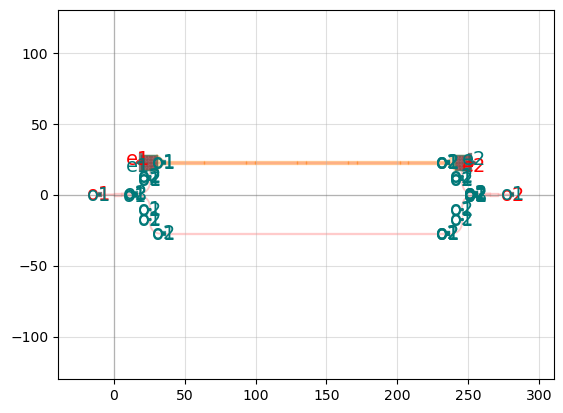

In [2]:
delta_length = 10
mzi_component = gf.components.mzi_phase_shifter_top_heater_metal(
    delta_length=delta_length
)
fig = mzi_component.plot()

def straight(wl=1.5, length=10.0, neff=2.4):
    wl0 = 1.5  # center wavelength for which the waveguide model is defined
    return sax.reciprocal({("o1", "o2"): np.exp(2j * np.pi * neff * length / wl)})


def mmi1x2():
    """Returns a perfect 1x2 splitter."""
    return sax.reciprocal(
        {
            ("o1", "o2"): 0.5**0.5,
            ("o1", "o3"): 0.5**0.5,
        }
    )


def bend_euler(wl=1.5, length=20.0):
    """Returns bend Sparameters with reduced transmission compared to a straight."""
    return {k: 0.99 * v for k, v in straight(wl=wl, length=length).items()}


class phase_shifter_heater:
    def __init__(self,
        wl: float = 1.55,
        neff: float = 2.34,
        length: float = 10,
        loss: float = 0.0,
        voltage = 0,
    ):
        self.wl = wl
        self.neff = neff
        self.length = length
        self.loss = loss
        self.voltage = voltage
        self.count = 0

    def __call__(self):
        """Returns simple phase shifter model"""
        deltaphi = self.voltage * np.pi
        phase = 2 * np.pi * self.neff * self.length / self.wl + deltaphi
        amplitude = np.asarray(10 ** (-self.loss * self.length / 20), dtype=complex)
        transmission = amplitude * np.exp(1j * phase)
        sdict = sax.reciprocal(
            {
                ("o1", "o2"): transmission,
            }
        )
        return sdict

models = {
    "bend_euler": bend_euler,
    "mmi1x2": mmi1x2,
    "straight": straight,
    "straight_heater_metal_undercut": phase_shifter_heater,
}

In [3]:
mzi_component = gf.components.mzi_phase_shifter_top_heater_metal(
    delta_length=delta_length
)
netlist = mzi_component.get_netlist()
mzi_circuit, temp = sax.circuit(netlist=netlist, models=models)

example = {"sxt":{"voltage":0}}
mzi_circuit(sxt = {"voltage": 0})
mzi_circuit(**{"sxt":{"voltage":0}})

S = mzi_circuit(wl=1.55)
S

{('o1', 'o1'): 0j,
 ('o2', 'o2'): 0j,
 ('o1', 'o2'): (-0.08108212759701816+0.724335988985032j),
 ('o2', 'o1'): (-0.08108212759701816+0.724335988985032j)}

Okay, so sax.circuit returns a flat_circuit. A flat circuit returns a _circuit function which can take as input 

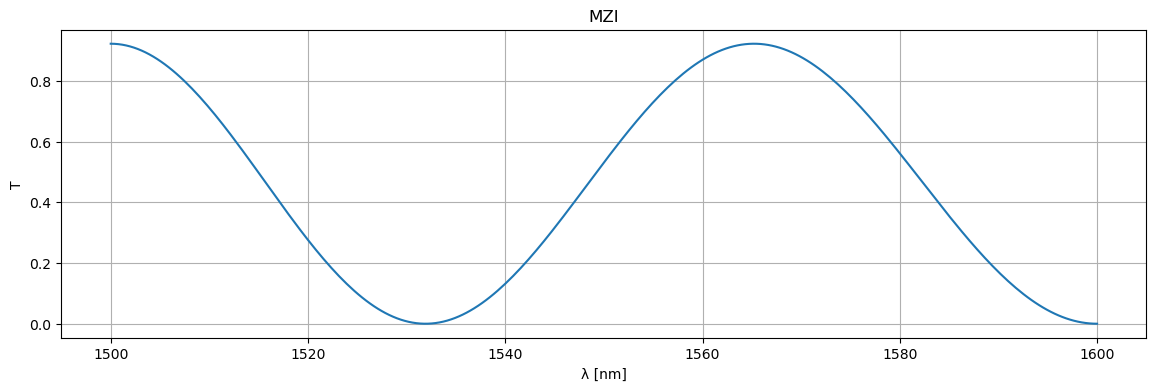

In [4]:
wl = np.linspace(1.5, 1.6, 256)
S = mzi_circuit(wl=wl)

plt.figure(figsize=(14, 4))
plt.title("MZI")
plt.plot(1e3 * wl, np.abs(S["o1", "o2"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.grid(True)
plt.show()

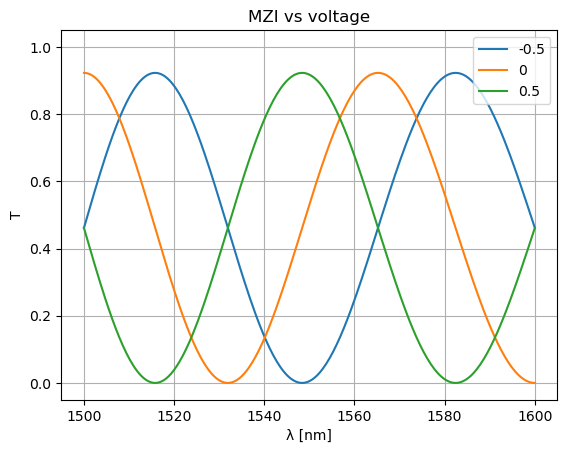

In [5]:
voltages = np.linspace(-1, 1, num=5)
voltages = [-0.5, 0, 0.5]

for voltage in voltages:
    S = mzi_circuit(
        wl=wl,
        sxt={"voltage": voltage},
    )
    plt.plot(wl * 1e3, abs(S["o1", "o2"]) ** 2, label=str(voltage))
    plt.xlabel("λ [nm]")
    plt.ylabel("T")
    plt.ylim(-0.05, 1.05)
    plt.grid(True)

plt.title("MZI vs voltage")
plt.legend()

## Can a component have memory? Create a version of the phase shifter which stores all prior voltages in a list and averages over them as an example

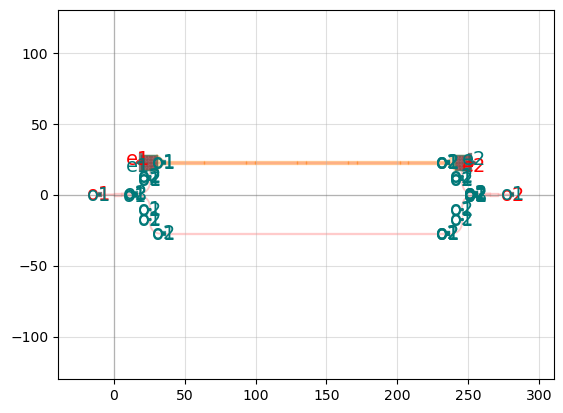

In [6]:
delta_length = 10
mzi_component = gf.components.mzi_phase_shifter_top_heater_metal(
    delta_length=delta_length
)
fig = mzi_component.plot()

def straight(wl=1.5, length=10.0, neff=2.4):
    wl0 = 1.5  # center wavelength for which the waveguide model is defined
    return sax.reciprocal({("o1", "o2"): np.exp(2j * np.pi * neff * length / wl)})


def mmi1x2():
    """Returns a perfect 1x2 splitter."""
    return sax.reciprocal(
        {
            ("o1", "o2"): 0.5**0.5,
            ("o1", "o3"): 0.5**0.5,
        }
    )


def bend_euler(wl=1.5, length=20.0):
    """Returns bend Sparameters with reduced transmission compared to a straight."""
    return {k: 0.99 * v for k, v in straight(wl=wl, length=length).items()}


class phase_shifter_heater:
    def __init__(self,
        wl: float = 1.55,
        neff: float = 2.34,
        length: float = 10,
        loss: float = 0.0,
        voltage = 0,
    ):
        print("Initializing circuit")
        self.wl = wl
        self.neff = neff
        self.length = length
        self.loss = loss
        self.voltage = voltage
        self.count = 0

    def set_voltage(self,voltage):
        self.voltage = voltage

    def __call__(self):
        print("CALL")
        """Returns simple phase shifter model"""
        deltaphi = self.voltage * np.pi
        phase = 2 * np.pi * self.neff * self.length / self.wl + deltaphi
        amplitude = np.asarray(10 ** (-self.loss * self.length / 20), dtype=complex)
        transmission = amplitude * np.exp(1j * phase)
        sdict = sax.reciprocal(
            {
                ("o1", "o2"): transmission,
            }
        )
        return sdict

models = {
    "bend_euler": bend_euler,
    "mmi1x2": mmi1x2,
    "straight": straight,
    "straight_heater_metal_undercut": phase_shifter_heater,
}

In [7]:
mzi_component = gf.components.mzi_phase_shifter_top_heater_metal(
    delta_length=delta_length
)
netlist = mzi_component.get_netlist()
#Creating the circuit
mzi_circuit, circuit_info = sax.circuit(netlist=netlist, models=models)
# print(mzi_circuit)
# print(temp)

# print(dir(mzi_circuit))
# print(mzi_circuit.__call__())

S1
Initializing circuit
CALL
S2
Initializing circuit
CALL


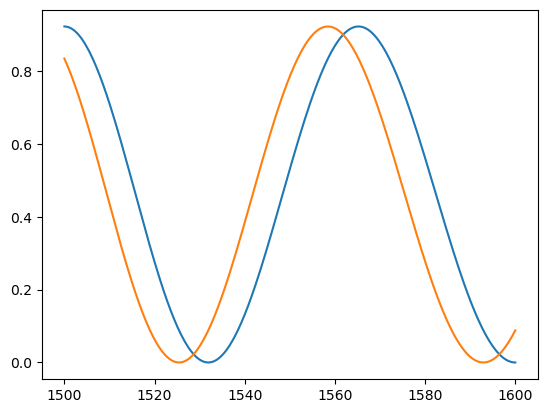

In [8]:
plt.figure()
# sax.circuit.evaluate_circuit()
from sax.backends import circuit_backends
evaluate_circuit = circuit_backends['default']

print("S1")
S1 = mzi_circuit(wl=wl,sxt={"voltage": 0.0},)
print("S2")
S2 = mzi_circuit(wl=wl,sxt={"voltage": 0.2},)
plt.plot(wl * 1e3, abs(S1["o1", "o2"]) ** 2)
plt.plot(wl * 1e3, abs(S2["o1", "o2"]) ** 2)

In [9]:
print(mzi_circuit)

<function _flat_circuit.<locals>._circuit at 0x00000161AA70AE60>
